# Zero-Shot-Learning Network (Inference)

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize

In [3]:
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.models import Sequential, Model, model_from_json

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set Configs

In [4]:
WORD2VEC_PATH = "./datasets/class_vectors.npy"
MODEL_PATH = "./weights/"

## Build Feature Extractors

In [5]:
def get_model():
    vgg_model = keras.applications.VGG16(include_top=True, weights='imagenet') # set true to get fc1 layer
    vgg_model.layers.pop() # remove output layer
    vgg_model.layers.pop() # remove fc2 layer
    
    vgg_input = vgg_model.input
    vgg_output = vgg_model.layers[-1].output
    
    model = Model(vgg_input, vgg_output)
    
    return model

In [6]:
get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
def get_features(model, resized_image):
    x = image.img_to_array(resized_image)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features

## Load ZSL Model

In [8]:
def load_model(model_path):
    with open(model_path + 'zsl_model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_path + 'zsl_model.h5')
    print("ZSL model is loaded.")
    
    return loaded_model

In [9]:
zsl_model = load_model(model_path=MODEL_PATH)

ZSL model is loaded.


## Inference!

In [10]:
IMAGE_PATH = './images/'
train_class = ['house', 'chicken', 'boy']
unseen_class = ['car', 'food', 'hand', 'man', 'airplane']

In [11]:
def main(image_path):
    
    for image in unseen_class:
        image = Image.open(IMAGE_PATH + image + '.jpg')
        plt.imshow(image)
        plt.show()

        print("Predicting...")

        # resize image
        image = image.resize((224, 224))

        # load pre-trained vgg16 model for feature extraction
        vgg_model = get_model()
        # extract image features
        image_features = get_features(vgg_model, image)
        # normalize the features with L2 norm
        image_features = normalize(image_features, norm='l2')

        # load ZSL model
        zsl_prediction = zsl_model.predict(image_features)

        # load word2vecs
        class_vectors = sorted(np.load(WORD2VEC_PATH), key=lambda x: x[0])
        class_names, vectors = zip(*class_vectors)
        class_names = list(class_names)
        vectors = np.asarray(vectors, dtype=np.float)

        # place word2vecs in KDTree
        tree = KDTree(vectors)
        # find closest word2vec and get prediction result
        dist_5, index_5 = tree.query(zsl_prediction, k=5)
        prediction_labels = [class_names[index] for index in index_5[0]]

        print("# --------------------------")
        print("# Zero-Shot Learning Score:")
        print("# --------------------------")
        for i, class_name in enumerate(prediction_labels):
            print("Rank %d: %s" %(i+1, class_name))

    return

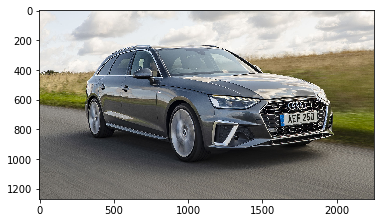

Predicting...
# --------------------------
# Zero-Shot Learning Score:
# --------------------------
Rank 1: vehicle
Rank 2: truck
Rank 3: car
Rank 4: house
Rank 5: woman


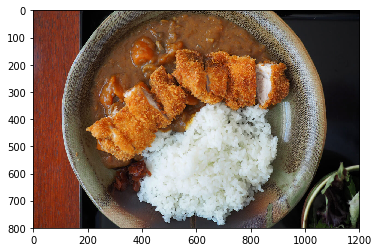

Predicting...
# --------------------------
# Zero-Shot Learning Score:
# --------------------------
Rank 1: chicken
Rank 2: bread
Rank 3: sandwich
Rank 4: food
Rank 5: watch


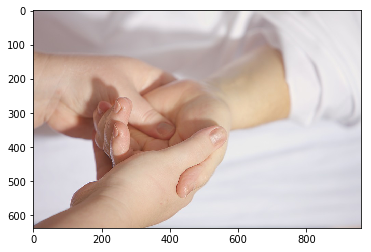

Predicting...
# --------------------------
# Zero-Shot Learning Score:
# --------------------------
Rank 1: arm
Rank 2: leg
Rank 3: hand
Rank 4: neck
Rank 5: ear


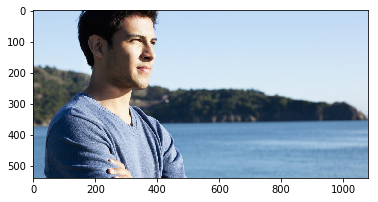

Predicting...
# --------------------------
# Zero-Shot Learning Score:
# --------------------------
Rank 1: house
Rank 2: woman
Rank 3: boy
Rank 4: child
Rank 5: arm


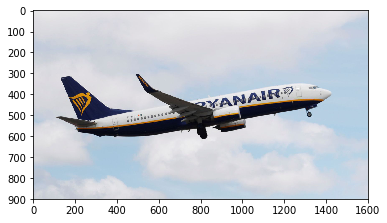

Predicting...
# --------------------------
# Zero-Shot Learning Score:
# --------------------------
Rank 1: house
Rank 2: child
Rank 3: boy
Rank 4: car
Rank 5: leg


In [12]:
if __name__ == '__main__':
    main(IMAGE_PATH)

---